In [1]:
import random
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import pickle
from tqdm import tqdm
import cv2

%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.nn import init
from torchvision import transforms
from torch.utils.data import Dataset
from numpy.core.multiarray import concatenate

In [3]:
# Use the GPU if you have one
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Visulize the dataset

In [4]:
img0_list = sorted(glob.glob("./data/Training/a/input/*_10.png"))
img1_list = sorted(glob.glob("./data/Training/a/input/*_11.png"))
flow_label_list = sorted(glob.glob("./data/Training/a/output-flow/*.png"))
frame_label_list = sorted(glob.glob("./data/Training/a/output-12/*.png"))
assert len(img0_list) == len(flow_label_list)
print ("Collected {} images".format(len(img1_list)))

Collected 394 images


Text(0.5, 1.0, 'Next Frame')

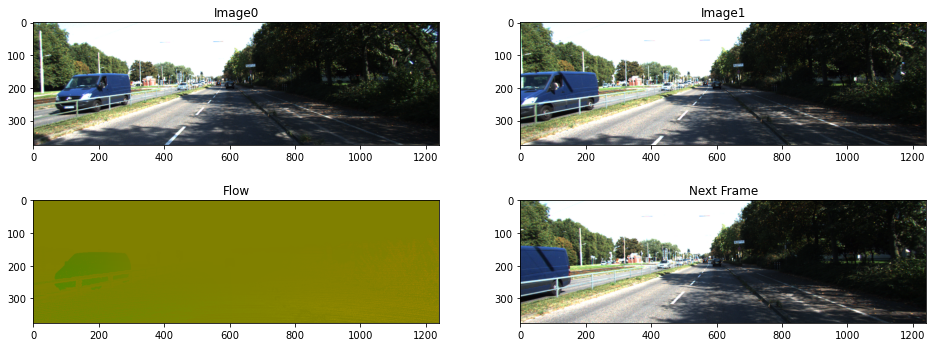

In [5]:
img0 = cv2.imread(img0_list[222])
img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
img1 = cv2.imread(img1_list[222])
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
flow = cv2.imread(flow_label_list[222])
flow = cv2.cvtColor(flow, cv2.COLOR_BGR2RGB)
frame = cv2.imread(frame_label_list[222])
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (16,6))
plt.subplot(2,2,1)
plt.imshow(img0)
plt.title('Image0')
plt.subplot(2,2,2)
plt.imshow(img1)
plt.title('Image1')
plt.subplot(2,2,3)
plt.imshow(flow)
plt.title('Flow')
plt.subplot(2,2,4)
plt.imshow(frame)
plt.title('Next Frame')

# Convert the flow data

In [6]:
def make_color_wheel():
    """
    Generate color wheel according Middlebury color code
    :return: Color wheel
    """
    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR
    colorwheel = np.zeros([ncols, 3])
    col = 0
    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.transpose(np.floor(255*np.arange(0, RY) / RY))
    col += RY
    # YG
    colorwheel[col:col+YG, 0] = 255 - np.transpose(np.floor(255*np.arange(0, YG) / YG))
    colorwheel[col:col+YG, 1] = 255
    col += YG
    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.transpose(np.floor(255*np.arange(0, GC) / GC))
    col += GC
    # CB
    colorwheel[col:col+CB, 1] = 255 - np.transpose(np.floor(255*np.arange(0, CB) / CB))
    colorwheel[col:col+CB, 2] = 255
    col += CB
    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.transpose(np.floor(255*np.arange(0, BM) / BM))
    col += + BM
    # MR
    colorwheel[col:col+MR, 2] = 255 - np.transpose(np.floor(255 * np.arange(0, MR) / MR))
    colorwheel[col:col+MR, 0] = 255

    return colorwheel

def compute_color(u, v):
    """
    compute optical flow color map
    :param u: optical flow horizontal map
    :param v: optical flow vertical map
    :return: optical flow in color code
    """
    [h, w] = u.shape
    img = np.zeros([h, w, 3])
    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0

    colorwheel = make_color_wheel()
    ncols = np.size(colorwheel, 0)
    rad = np.sqrt(u**2+v**2)
    a = np.arctan2(-v, -u) / np.pi
    fk = (a+1) / 2 * (ncols - 1) + 1
    k0 = np.floor(fk).astype(int)
    k1 = k0 + 1
    k1[k1 == ncols+1] = 1
    f = fk - k0

    for i in range(0, np.size(colorwheel,1)):
        tmp = colorwheel[:, i]
        col0 = tmp[k0-1] / 255
        col1 = tmp[k1-1] / 255
        col = (1-f) * col0 + f * col1

        idx = rad <= 1
        col[idx] = 1-rad[idx]*(1-col[idx])
        notidx = np.logical_not(idx)

        col[notidx] *= 0.75
        img[:, :, i] = np.uint8(np.floor(255 * col*(1-nanIdx)))

    return img

def flow_to_image(flow):
    """
    Convert flow into middlebury color code image
    :param flow: optical flow map
    :return: optical flow image in middlebury color
    """
    u = flow[0]
    v = flow[1]

    maxu = -999.
    maxv = -999.
    minu = 999.
    minv = 999.
    UNKNOWN_FLOW_THRESH = 1e7
    SMALLFLOW = 0.0
    LARGEFLOW = 1e8

    idxUnknow = (abs(u) > UNKNOWN_FLOW_THRESH) | (abs(v) > UNKNOWN_FLOW_THRESH)
    u[idxUnknow] = 0
    v[idxUnknow] = 0

    maxu = max(maxu, np.max(u))
    minu = min(minu, np.min(u))
    maxv = max(maxv, np.max(v))
    minv = min(minv, np.min(v))

    rad = np.sqrt(u ** 2 + v ** 2)
    maxrad = max(-1, np.max(rad))

    u = u/(maxrad + np.finfo(float).eps)
    v = v/(maxrad + np.finfo(float).eps)

    img = compute_color(u, v)
    idx = np.repeat(idxUnknow[:, :, np.newaxis], 3, axis=2)
    img[idx] = 0

    return np.uint8(img)

(2, 360, 1224)


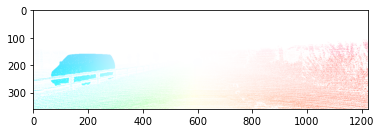

In [7]:
flow = np.float64(np.array(cv2.imread(flow_label_list[222], cv2.IMREAD_UNCHANGED)))
flow = (np.concatenate(([flow[:,:,2]],[flow[:,:,1]]), axis=0)  - 2**15) / 64
flow = flow[:,0:360,0:1224]

#flow = np.array(train_dataset[0][1])
print(flow.shape)
img = flow_to_image(flow)
plt.imshow(img)
plt.show()

# Define the Network

In [8]:
def conv(batchNorm, in_planes, out_planes, kernel_size=3, stride=1):
    if batchNorm:
        return nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=(kernel_size-1)//2, bias=False),
            nn.BatchNorm2d(out_planes),
            nn.LeakyReLU(0.1,inplace=True)
        )
    else:
        return nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=(kernel_size-1)//2, bias=True),
            nn.LeakyReLU(0.1,inplace=True)
        )

def deconv(in_planes, out_planes):
    return nn.Sequential(
        nn.ConvTranspose2d(in_planes, out_planes, kernel_size=4, stride=2, padding=1, bias=True),
        nn.LeakyReLU(0.1,inplace=True)
    )

def predict_flow(in_planes):
    return nn.Conv2d(in_planes,2,kernel_size=3,stride=1,padding=1,bias=True)

def predict_frame(in_planes):
    return nn.Conv2d(in_planes,3,kernel_size=3,stride=1,padding=1,bias=True)


class NextFlow(nn.Module):
    def __init__(self, input_channels = 6, batchNorm=True):
        super(NextFlow,self).__init__()

        self.batchNorm = batchNorm
        self.conv1   = conv(self.batchNorm,  input_channels,   64, kernel_size=7, stride=2)
        self.conv2   = conv(self.batchNorm,  64,  128, kernel_size=5, stride=2)
        self.conv3   = conv(self.batchNorm, 128,  256, kernel_size=5, stride=2)
        self.conv3_1 = conv(self.batchNorm, 256,  256)
        self.conv4   = conv(self.batchNorm, 256,  512, stride=2)
        self.conv4_1 = conv(self.batchNorm, 512,  512)
        self.conv5   = conv(self.batchNorm, 512,  512, stride=2)
        self.conv5_1 = conv(self.batchNorm, 512,  512)
        self.conv6   = conv(self.batchNorm, 512, 1024, stride=2)
        self.conv6_1 = conv(self.batchNorm, 1024, 1024)

        ###################### Flow ####################
        self.deconv5 = deconv(1024,512)
        self.deconv4 = deconv(1026,256)
        self.deconv3 = deconv(770,128)
        self.deconv2 = deconv(386,64)

        self.predict_flow6 = predict_flow(1024)
        self.predict_flow5 = predict_flow(1026)
        self.predict_flow4 = predict_flow(770)
        self.predict_flow3 = predict_flow(386)
        self.predict_flow2 = predict_flow(194)

        self.upsampled_flow6_to_5 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)
        self.upsampled_flow5_to_4 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)
        self.upsampled_flow4_to_3 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)
        self.upsampled_flow3_to_2 = nn.ConvTranspose2d(2, 2, 4, 2, 1, bias=False)

        ###################### Frame ####################
        self.deconv5_0 = deconv(1024,512)
        self.deconv4_0 = deconv(1027,256)
        self.deconv3_0 = deconv(771,128)
        self.deconv2_0 = deconv(387,64)

        self.predict_flow6_0 = predict_frame(1024)
        self.predict_flow5_0 = predict_frame(1027)
        self.predict_flow4_0 = predict_frame(771)
        self.predict_flow3_0 = predict_frame(387)
        self.predict_flow2_0 = predict_frame(195)

        self.upsampled_flow6_to_5_0 = nn.ConvTranspose2d(3, 3, 4, 2, 1, bias=False)
        self.upsampled_flow5_to_4_0 = nn.ConvTranspose2d(3, 3, 4, 2, 1, bias=False)
        self.upsampled_flow4_to_3_0 = nn.ConvTranspose2d(3, 3, 4, 2, 1, bias=False)
        self.upsampled_flow3_to_2_0 = nn.ConvTranspose2d(3, 3, 4, 2, 1, bias=False)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if m.bias is not None:
                    init.uniform_(m.bias)
                init.xavier_uniform_(m.weight)

            if isinstance(m, nn.ConvTranspose2d):
                if m.bias is not None:
                    init.uniform_(m.bias)
                init.xavier_uniform_(m.weight)
                # init_deconv_bilinear(m.weight)
        self.upsample1 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False)
        self.upsample1_0 = nn.Upsample(scale_factor=4, mode='bilinear', align_corners=False)

    def forward(self, x):

        out_conv1 = self.conv1(x)
        out_conv2 = self.conv2(out_conv1)
        out_conv3 = self.conv3_1(self.conv3(out_conv2))
        out_conv4 = self.conv4_1(self.conv4(out_conv3))
        out_conv5 = self.conv5_1(self.conv5(out_conv4))
        out_conv6 = self.conv6_1(self.conv6(out_conv5))

        ###### Branch1 ######
        
        flow6       = self.predict_flow6(out_conv6)
        flow6_up    = self.upsampled_flow6_to_5(flow6)
        out_deconv5 = self.deconv5(out_conv6)
        
        concat5 = torch.cat((out_conv5,out_deconv5,flow6_up),1)
        flow5       = self.predict_flow5(concat5)
        flow5_up    = self.upsampled_flow5_to_4(flow5)
        out_deconv4 = self.deconv4(concat5)
        
        concat4 = torch.cat((out_conv4,out_deconv4,flow5_up),1)
        flow4       = self.predict_flow4(concat4)
        flow4_up    = self.upsampled_flow4_to_3(flow4)
        out_deconv3 = self.deconv3(concat4)
        
        concat3 = torch.cat((out_conv3,out_deconv3,flow4_up),1)
        flow3       = self.predict_flow3(concat3)
        flow3_up    = self.upsampled_flow3_to_2(flow3)
        out_deconv2 = self.deconv2(concat3)

        concat2 = torch.cat((out_conv2,out_deconv2,flow3_up),1)
        flow2 = self.predict_flow2(concat2)
        flow1 = self.upsample1(flow2)

        ##### Branch2 #####

        frame6       = self.predict_flow6_0(out_conv6)
        frame6_up    = self.upsampled_flow6_to_5_0(frame6)
        out_deconv5_0 = self.deconv5_0(out_conv6)
        
        concat5_0 = torch.cat((out_conv5,out_deconv5_0,frame6_up),1)
        frame5       = self.predict_flow5_0(concat5_0)
        frame5_up    = self.upsampled_flow5_to_4_0(frame5)
        out_deconv4_0 = self.deconv4_0(concat5_0)
        
        concat4_0 = torch.cat((out_conv4,out_deconv4_0,frame5_up),1)
        frame4       = self.predict_flow4_0(concat4_0)
        frame4_up    = self.upsampled_flow4_to_3_0(frame4)
        out_deconv3_0 = self.deconv3_0(concat4_0)
        
        concat3_0 = torch.cat((out_conv3,out_deconv3_0,frame4_up),1)
        frame3       = self.predict_flow3_0(concat3_0)
        frame3_up    = self.upsampled_flow3_to_2_0(frame3)
        out_deconv2_0 = self.deconv2_0(concat3_0)

        concat2_0 = torch.cat((out_conv2,out_deconv2_0,frame3_up),1)
        frame2 = self.predict_flow2_0(concat2_0)
        frame1 = self.upsample1_0(frame2)

        return flow1, frame1 


# Prepare data

In [9]:
class KITTIDataset(Dataset):
    def __init__(self, img0_path_list, img1_path_list, flow_label_path_list, frame_label_path_list):
        self.img0_path_list = img0_path_list
        self.img1_path_list = img1_path_list
        self.flow_label_path_list = flow_label_path_list
        self.frame_label_path_list = frame_label_path_list

        
        self.img_list, self.flow_list, self.frame_list = self.preprocess()
        
    def __len__(self):
        return len(self.img_list)

    def preprocess(self):

        img_list, flow_list, frame_list = [], [], []
        for idx in tqdm(range(len(self.flow_label_path_list))):
            img0 = cv2.imread(self.img0_path_list[idx])
            img0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
            img1 = cv2.imread(self.img1_path_list[idx])
            img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
            img = np.concatenate((img0,img1), axis=2)
            img = img[40:360,0:1024,:]
            flow = np.float64(np.array(cv2.imread(self.flow_label_path_list[idx], cv2.IMREAD_UNCHANGED)))
            flow = (np.concatenate(([flow[:,:,2]],[flow[:,:,1]]), axis=0)  - 2**15) / 64
            flow = flow[:,40:360,0:1024]
            frame = cv2.imread(self.frame_label_path_list[idx])
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  
            frame = frame[40:360,0:1024,:]        
            
            img_list.append(img)
            flow_list.append(flow)
            frame_list.append(frame)
        return img_list, flow_list, frame_list
                    
                    
    def __getitem__(self, idx):
        img = self.img_list[idx]
        flow = self.flow_list[idx]
        frame = self.frame_list[idx]

        img = torch.Tensor(img).permute(2,0,1)
        flow = torch.Tensor(flow)
        frame = torch.Tensor(frame).permute(2,0,1)      
        
        
        return img/255., flow/255., frame/255

In [10]:
exam_dataset = KITTIDataset(img0_list[0:10], img1_list[0:10], flow_label_list[0:10], frame_label_list[0:10])

100%|██████████| 10/10 [00:00<00:00, 14.19it/s]


# Load in the trained network and do prediction

In [11]:
checkpoint_path = './model/NFmodelEpoch99.pth'
net = NextFlow(input_channels=6, batchNorm=True)
net.load_state_dict(torch.load(checkpoint_path))
net.eval()
net.to(device)
# This shows the number of parameters in the network
n_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print('Number of parameters in network: ', n_params)

Number of parameters in network:  53345261


In [12]:
# Define a function for prediction/testing
def predict_img(net, img):
    net.eval()
    img = img.to(device)

    with torch.no_grad():
               
        img = img.unsqueeze(0)
        pred, pred0 = net(img)
        pred = pred * 255
        pred0 = pred0 * 255

    return pred, pred0

In [13]:
def display_results(net, input_imgs):
    
      plt.figure(figsize = (16,9))
    
      pred, pred0 = predict_img(net=net, img=input_imgs[0].to(device))

      plt.subplot(3,2,1)
      pred = flow_to_image(np.array(pred.squeeze(0).cpu()))
      plt.imshow(pred.astype(np.uint8))
      plt.title('pred flow')
      plt.subplot(3,2,2)
      acflow = flow_to_image(np.array(input_imgs[1]))
      plt.imshow(acflow)
      plt.title('actual flow')

      plt.subplot(3,2,3)
      time0 = np.array(input_imgs[0][0:3].permute(1,2,0).cpu())*255
      plt.imshow(time0.astype(np.uint8))
      plt.title('time 0 frame')
      plt.subplot(3,2,4)
      time1 = np.array(input_imgs[0][3:6].permute(1,2,0).cpu())*255
      plt.imshow(time1.astype(np.uint8))
      plt.title('time 1 frame')

      plt.subplot(3,2,5)
      plt.imshow(np.array(pred0.squeeze(0).permute(1,2,0).cpu()).astype(np.uint8))
      plt.title('pred next frame')
      plt.subplot(3,2,6)
      plt.imshow(np.array(input_imgs[2].permute(1,2,0).cpu()))
      plt.title('actual next frame')

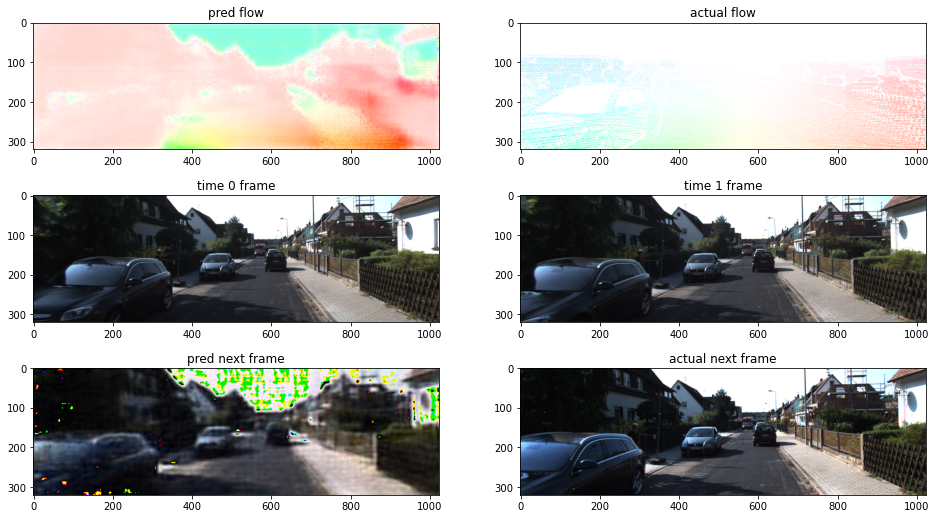

In [18]:
display_results(net, exam_dataset[7])